In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Simple Bandit algorithms

bernoulli bandit is used below

In [3]:
import itertools

from joblib import Parallel, delayed

from bandits.bandits import BernoulliBandit
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

In [4]:
np.random.seed(2)
N_SIMULATIONS = 20
T = 10000
K = 5

eps = 1e-2  # probability of exploration
alpha = 1

In [5]:
agents = {
    f"EpsilonGreedy {eps=}": lambda bandit: EpsilonGreedyAgent(bandit=bandit, eps=eps),
    "UCB1": lambda bandit: UCB1Agent(bandit=bandit, alpha=alpha),
    "ThompsonSampling": lambda bandit: ThompsonSamplingBetaAgent(bandit=bandit),
}

In [6]:
np.random.seed(1)
pp = []
agent_to_regret = {name: [] for name in agents.keys()}

for n_simulation in tqdm(range(N_SIMULATIONS)):
    probs = np.random.uniform(0, 1, size=K)
    pp.append(probs)

    for name, agent_func in agents.items():
        np.random.seed(n_simulation)
        bandit = BernoulliBandit(probs=probs)
        agent = agent_func(bandit)
        for t in range(T):
            agent.take_action()
        agent_to_regret[name].append(np.max(probs) - agent.reward_history)

  0%|          | 0/20 [00:00<?, ?it/s]

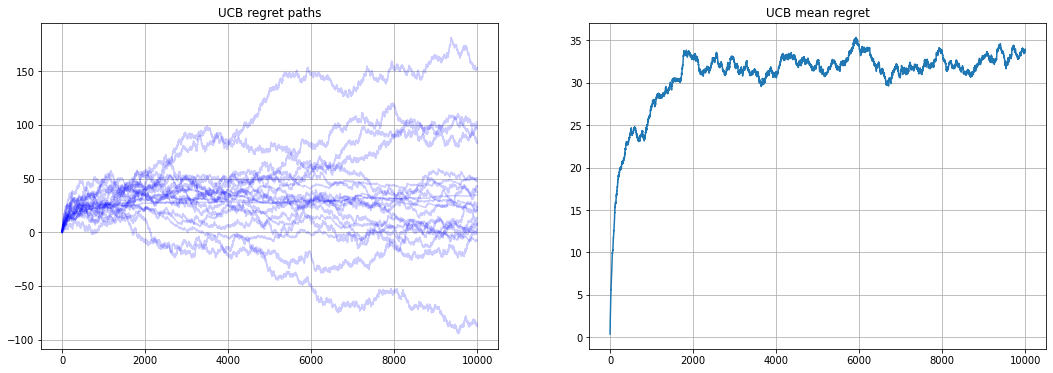

In [7]:
fig,axs=plt.subplots(figsize=(18, 6))

ts = np.arange(T)
plt.subplot(1, 2, 1)
for y in agent_to_regret['UCB1']:
    plt.plot(np.cumsum(y), color='blue', alpha=0.2)
plt.title('UCB regret paths')
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(x=ts, y=np.cumsum(np.mean(agent_to_regret['UCB1'], axis=0)))
plt.title('UCB mean regret')
plt.grid()

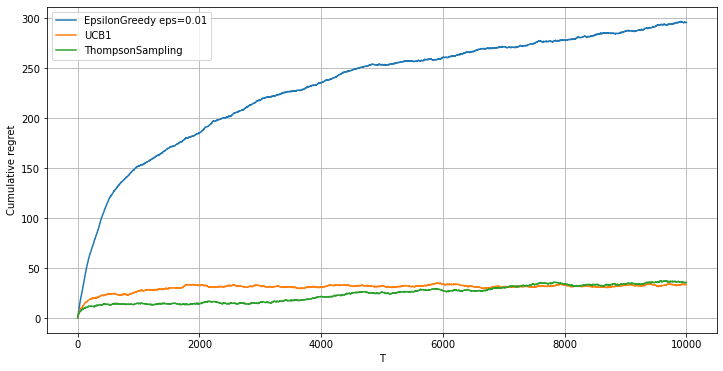

In [8]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.cumsum(np.mean(regret, axis=0)), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

armsarms> parallel computation

the sequential takes too much time for a large number of iterations

In [9]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000
K = 5

eps = 1e-2# probability of exploration
alpha = 1

In [10]:
def simulate_agent(agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    bandit = BernoulliBandit(probs=probs)
    
    name, agent_func = agent_tuple
    agent = agent_func(bandit)

    for t in range(T):
        agent.take_action()
    regret = np.max(probs) - agent.reward_history
    return rng_seed, name, regret

In [11]:
agent_funcs = [
    (f"EpsilonGreedy {eps=}", lambda bandit: EpsilonGreedyAgent(bandit=bandit, eps=eps)),
    ("UCB1", lambda bandit: UCB1Agent(bandit=bandit, alpha=alpha)),
    ("ThompsonSampling", lambda bandit: ThompsonSamplingBetaAgent(bandit=bandit)),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [12]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/150 [00:00<?, ?it/s]

In [13]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [14]:
results_df.head()

,simulation,algorithm,regret
0,0,EpsilonGreedy eps=0.01,"[-0.04967086776956786, 0.9503291322304321, 0.9..."
1,0,UCB1,"[0.9503291322304321, -0.04967086776956786, -0...."
2,0,ThompsonSampling,"[0.9503291322304321, -0.04967086776956786, 0.9..."
3,1,EpsilonGreedy eps=0.01,"[0.9503291322304321, 0.9503291322304321, 0.950..."
4,1,UCB1,"[0.9503291322304321, 0.9503291322304321, -0.04..."


In [15]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

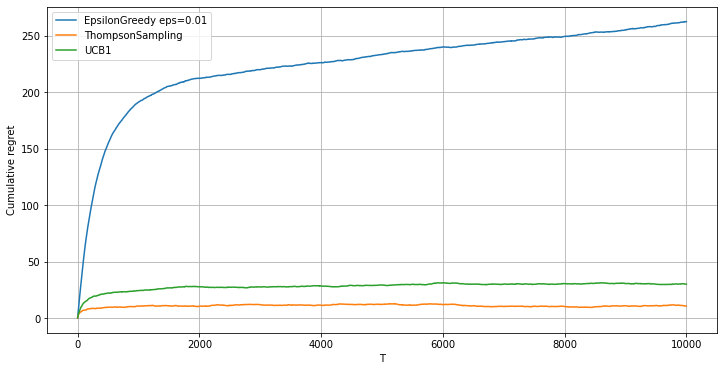

In [16]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.cumsum(np.mean(regret, axis=0)), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();